###**Importando Bibliotecas**

In [76]:
!pip install pymupdf
!pip install wordcloud matplotlib

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import pymupdf
import sys
import pathlib
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords.words('english')
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### **Web-Scrapping Results**

Link: [Gutenberg](https://www.gutenberg.org/ebooks/results/)

```

linhas_pares = document.querySelectorAll('.evenrow');
linhas_impares = document.querySelectorAll('.oddrow');

total = [linhas_impares, linhas_pares]

links = []
for (let i = 0; i < total.length; i++) {
  for(let x=0 ; x<total[i].length; x++){
      celula = total[i][x].cells[3].querySelector('a').href
      console.log(celula)
      links.push(celula)
  }
}

pdfs = []
texs = []

for(let x =0; x<links.length; x++){
    num = links[x].split('/')
    pdfs.push((links[x]+ "/"+num[num.length-1]+"-pdf.pdf").replace('ebooks', 'files'))
    texs.push((links[x] + '/'+num[num.length-1]+"-t"+'/'+num[num.length-1]+"-t.tex").replace('ebooks', 'files'))
}
```



In [78]:
files_math = ['https://www.gutenberg.org/files/7825/7825-pdf.pdf', 'https://www.gutenberg.org/files/31246/31246-pdf.pdf', 'https://www.gutenberg.org/files/29913/29913-pdf.pdf', 'https://www.gutenberg.org/files/13447/13447-pdf.pdf', 'https://www.gutenberg.org/files/40395/40395-pdf.pdf', 'https://www.gutenberg.org/files/31061/31061-pdf.pdf', 'https://www.gutenberg.org/files/13693/13693-pdf.pdf', 'https://www.gutenberg.org/files/57355/57355-pdf.pdf', 'https://www.gutenberg.org/files/26373/26373-pdf.pdf']
files_not_math = ["https://www.gutenberg.org/files/39535/39535-pdf.pdf","https://www.gutenberg.org/files/39273/39273-pdf.pdf","https://www.gutenberg.org/files/27531/27531-pdf.pdf","https://www.gutenberg.org/files/15114/15114-pdf.pdf","https://www.gutenberg.org/files/32625/32625-pdf.pdf","https://www.gutenberg.org/files/26495/26495-pdf.pdf","https://www.gutenberg.org/files/36884/36884-pdf.pdf","https://www.gutenberg.org/files/10836/10836-pdf.pdf","https://www.gutenberg.org/files/57359/57359-pdf.pdf"]

### **Preparando Arquivos**

In [79]:
import requests
import pymupdf
import pathlib
import re
from typing import Union, List

def filter_page_numbers(text):
    var = text.split('\n')
    return ''.join(var[2:])

def Extrai_texto(arq: str, output_name: str, paginas: Union[str, int, List[int], None] = None, output_dir: str = ".") -> None:
    output_path = pathlib.Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    r = requests.get(arq)
    doc = pymupdf.Document(stream=r.content)

    try:
        page_numbers = parse_page_range(paginas, len(doc))
        texts = []
        for pg in page_numbers:
            texts.append(doc[pg].get_text())

        filtered_texts = []
        for text in texts:
            filtered = filter_page_numbers(text)
            if filtered:
                filtered_texts.append(filtered)

        text = " ".join(filtered_texts)

        if len(page_numbers) == 1:
            suffix = f"_p{page_numbers[0]}"
        elif len(page_numbers) == len(doc):
            suffix = "_full"
        else:
            suffix = f"_pages{'-'.join(map(str, sorted(page_numbers)))}"

        output_file = output_path / f"{output_name}.txt"
        output_file.write_bytes(text.encode('utf-8', errors='replace'))
    finally:
        doc.close()

def parse_page_range(paginas: Union[str, int, List[int], None], total_pages: int) -> List[int]:
    if paginas is None:
        return list(range(total_pages))

    if isinstance(paginas, int):
        return [paginas]

    if isinstance(paginas, list):
        return paginas

    if isinstance(paginas, str):
        page_numbers = set()
        parts = [p.strip() for p in paginas.split(',')]

        for part in parts:
            if '-' in part:
                start, end = map(int, part.split('-'))
                page_numbers.update(range(start, end + 1))
            else:
                page_numbers.add(int(part))

        return sorted(page_numbers)

    raise ValueError("Formato de páginas inválido. Use None, int, lista ou string no formato '1-3,5'")


In [80]:
for x in range(len(files_math)):

  try:
    Extrai_texto(
        files_math[x],
        f"{x:03d}",
        '10-60',
        output_dir="math"
    )
  except:
    print("Error: ", x)

for x in range(len(files_not_math)):

  try:
    Extrai_texto(
        files_not_math[x],
        f"{x:03d}",
        '10-60',
        output_dir="not_math"
    )
  except:
    print("Error: ", x)


Error:  0
Error:  3


###**Revisando Arquivos**

In [81]:
import random
import re

def remove_trechos_aleatorios(nome_arquivo, qnt_trechos=2, qnt_palavras=5, total=False):
    """
    Remove trechos aleatórios de um texto e retorna os trechos removidos ou o texto segmentado.

    Args:
        nome_arquivo (str): Caminho do arquivo a ser processado
        qnt_trechos (int): Quantidade de trechos a remover (quando total=False)
        qnt_palavras (int): Tamanho de cada segmento em palavras
        total (bool): Se True, retorna todo o texto segmentado em partes de qnt_palavras

    Returns:
        list: Lista de trechos removidos (total=False) ou lista de todos os segmentos (total=True)
    """
    with open(nome_arquivo, 'r', encoding='utf-8') as f:
        texto = f.read()

    palavras = re.findall(r'\S+\s*', texto)
    if total:
        segmentos = []
        for i in range(0, len(palavras), qnt_palavras):
            segmento = ''.join(palavras[i:i+qnt_palavras]).strip()
            if segmento:
                segmentos.append(segmento)
        return segmentos
    else:
        trechos_removidos = []
        for _ in range(qnt_trechos):
            if len(palavras) < qnt_palavras:
                break

            pos = random.randint(0, len(palavras) - qnt_palavras)
            trecho = ''.join(palavras[pos:pos+qnt_palavras])
            trechos_removidos.append(trecho.strip())
            del palavras[pos:pos+qnt_palavras]

        return trechos_removidos

In [82]:
remove_trechos_aleatorios('/content/not_math/005.txt', 2, 20)

['difference betweena correct and an incorrect performance of those processes. Thereason for thus limiting our design, is evident. It has',
 'to give whatever provisionaldefinition he pleases of his own subject. But sufficient reasonswill, I believe, unfold themselves as we advance,']

In [83]:
remove_trechos_aleatorios('/content/math/000.txt', 2, 20)


['straight line is drawn in theparallelogram ξλ ∥ϵζ, and upon it a plane is erected per-pendicular to αγ, the circle',
 '. . . . *** END OF THIS PROJECT GUTENBERG EBOOK GEOMETRICAL SOLUTIONS ******** This file should be named 7825-pdf.pdf']

###**Data Cleaning**

In [84]:
def book_cleaning(sample):
      sample_punc_removed = [char for char in sample if char not in string.punctuation and char not in '1234567890']
      sample_punc_removed_join = ''.join(sample_punc_removed)
      sample_punc_removed_join_clean = [word for word in sample_punc_removed_join.split() if word.lower() not in stopwords.words('english')]
      return sample_punc_removed_join_clean

In [85]:
print(book_cleaning(remove_trechos_aleatorios('/content/math/000.txt', 1, 20)[0]))
print(book_cleaning(remove_trechos_aleatorios('/content/not_math/000.txt', 1, 20)[0]))

['renamedCreating', 'works', 'public', 'domain', 'print', 'editions', 'means', 'noone', 'owns', 'United', 'States', 'copyright', 'works']
['form', 'charity', 'grew', 'gradually', 'inthe', 'early', 'part', 'middle', 'ages', 'said', 'one', 'existed']


###**Criando Data Frame**

In [86]:
import pandas as pd

def Cria_DF(tamanho, palavras):

  math = []
  not_math = []
  for i in range(9):
    math = math + remove_trechos_aleatorios(f'/content/math/{i:03d}.txt', tamanho, palavras, total=True)
    not_math = not_math +  remove_trechos_aleatorios(f'/content/not_math/{i:03d}.txt', tamanho, palavras, total=True)

  print(len(math), len(not_math[:len(math)]))
  math_series = pd.Series(math)
  not_math_series = pd.Series(not_math)

  math = list(math_series.apply(book_cleaning))
  not_math = list(not_math_series.apply(book_cleaning))

  labels = [1]* len(math) + [0]*len(not_math)

  df =  pd.DataFrame({'X': math + not_math[:len(math)] ,
                      'y': labels[:len(math)*2]
                      })
  df = df.sample(frac=1).reset_index(drop=True)
  return df
df = Cria_DF(1, 80)

print(df)

1545 1545
                                                      X  y
0     [fact, Says, one, party, “Alcoholin, every, fo...  0
1     [–Notes, §§, CHAPTER, IXON, SUBSTITUTION, GROU...  1
2     [GL, perpendicular, Gupon, SPGL, PN, SA, AX, n...  1
3     [diﬀerent, way, viz, ﬁnding, length, theshadow...  1
4     [given, fact, fulfils, conditions, whetherfact...  0
...                                                 ... ..
3085  [ventureto, enter, details, mention, appearanc...  1
3086  [one, one, correspondencewith, triads, values,...  1
3087  [mentionsthe, following, Theætetus, Athens, ma...  1
3088  [θ, isits, center, gravity, cylinder, µν, cone...  1
3089  [middle, terms, frompropositions, without, reg...  0

[3090 rows x 2 columns]


In [87]:
df['X_str'] = df['X'].apply(lambda palavras: ' '.join(palavras))

###**Explorando DataFrame**

<Axes: >

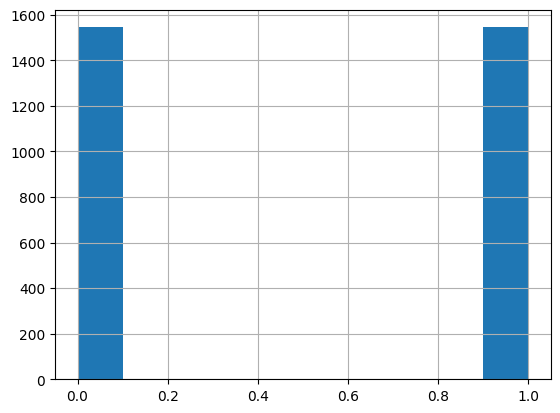

In [88]:
df['y'].hist()

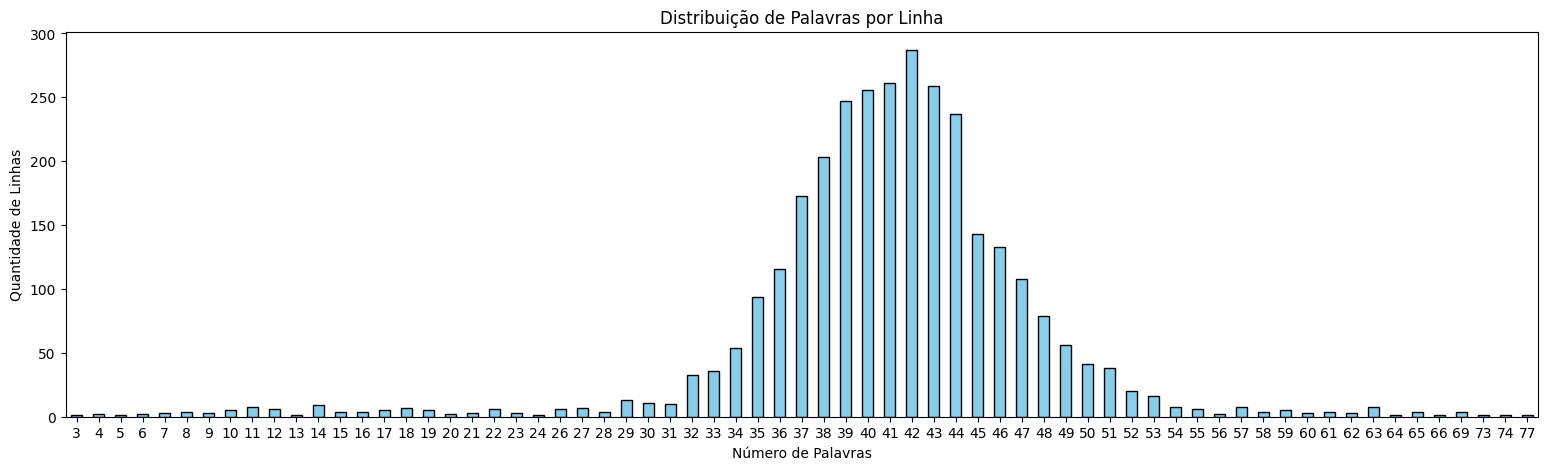

In [89]:
plt.figure(figsize=(19, 5))
df["X"].apply(len).value_counts().sort_index().plot(
    kind="bar",
    color="skyblue",
    edgecolor="black"
)

plt.title("Distribuição de Palavras por Linha")
plt.xlabel("Número de Palavras")
plt.ylabel("Quantidade de Linhas")
plt.xticks(rotation=0)

plt.show()

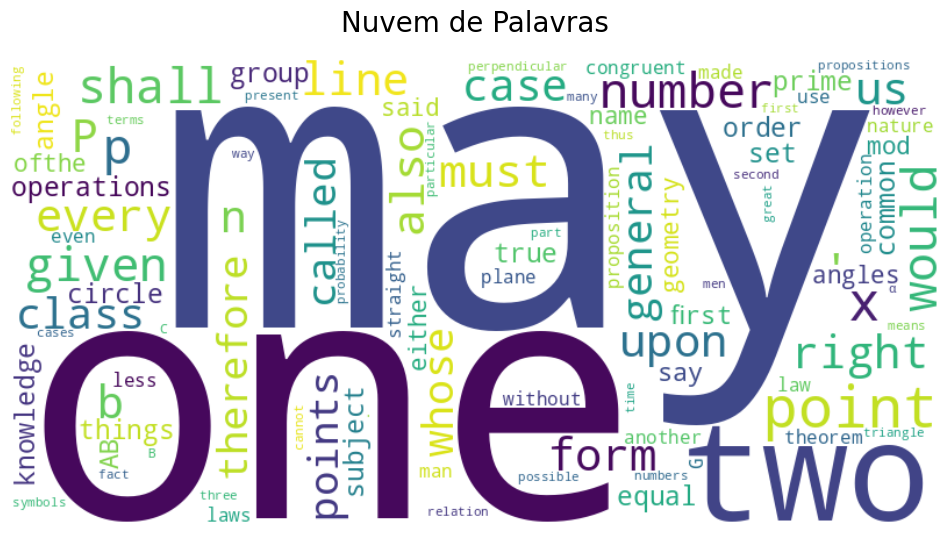

In [90]:
todas_palavras = [palavra for lista in df['X'] for palavra in lista]
contagem_palavras = Counter(todas_palavras)
wc = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    max_words=100
).generate_from_frequencies(contagem_palavras)


plt.figure(figsize=(12, 8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Nuvem de Palavras", fontsize=20, pad=20)
plt.show()

In [91]:
df.head()

,X,y,X_str
0,"[fact, Says, one, party, “Alcoholin, every, fo...",0,fact Says one party “Alcoholin every form leas...
1,"[–Notes, §§, CHAPTER, IXON, SUBSTITUTION, GROU...",1,–Notes §§ CHAPTER IXON SUBSTITUTION GROUPS PRI...
2,"[GL, perpendicular, Gupon, SPGL, PN, SA, AX, n...",1,GL perpendicular Gupon SPGL PN SA AX normals d...
3,"[diﬀerent, way, viz, ﬁnding, length, theshadow...",1,diﬀerent way viz ﬁnding length theshadow pyram...
4,"[given, fact, fulfils, conditions, whetherfact...",0,given fact fulfils conditions whetherfacts fou...


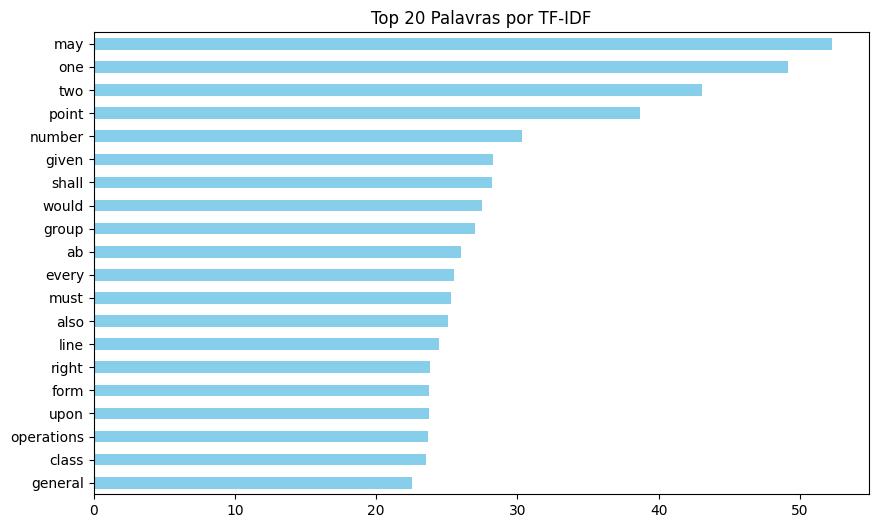

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['X_str'])

df_tfidf = pd.DataFrame(X.T.toarray(), index=vectorizer.get_feature_names_out())
top_words = df_tfidf.sum(axis=1).sort_values(ascending=False).head(20)

top_words.plot(kind='barh', figsize=(10,6), color='skyblue')
plt.title("Top 20 Palavras por TF-IDF")
plt.gca().invert_yaxis()
plt.show()


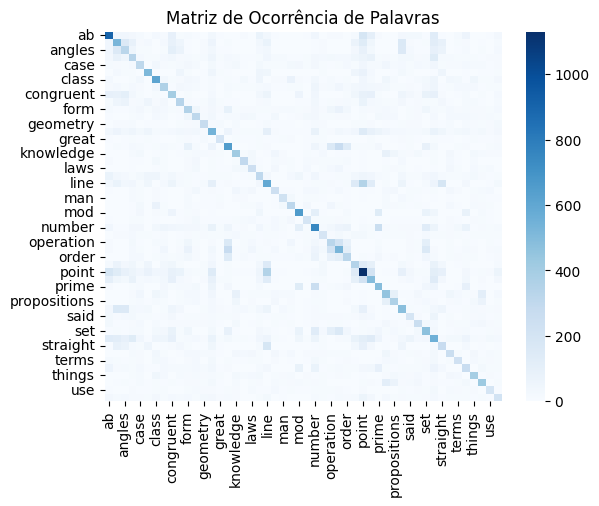

In [93]:
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns

vectorizer = CountVectorizer(max_features=50, stop_words='english')
X = vectorizer.fit_transform(df['X_str'])
df_words = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

cooc_matrix = df_words.T.dot(df_words)
sns.heatmap(cooc_matrix, cmap='Blues')
plt.title("Matriz de Ocorrência de Palavras")
plt.show()


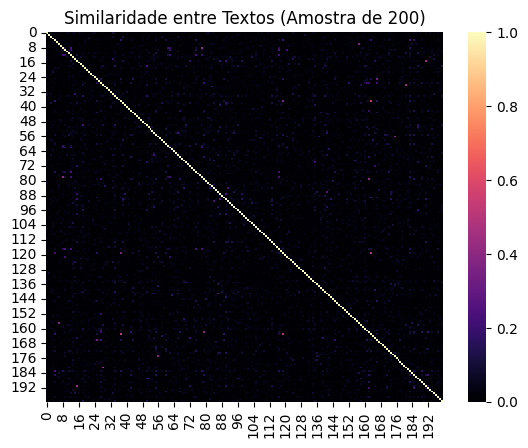

In [94]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

amostra = df.sample(200)
tfidf = TfidfVectorizer()

X_sample = tfidf.fit_transform(amostra['X_str'])
similaridade = cosine_similarity(X_sample)

sns.heatmap(similaridade, cmap='magma')
plt.title("Similaridade entre Textos (Amostra de 200)")
plt.show()

###**Implementando Tokenizer**

In [95]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
count_matrix = vectorizer.fit_transform(df['X_str'])

print(list(vectorizer.get_feature_names_out()))
print(count_matrix.toarray().shape)

['aa', 'aaa', 'aaanand', 'aaand', 'aaanwhen', 'aaasaaaraasa', 'aab', 'aacc', 'aacompwhence', 'aafrom', 'aagain', 'aaha', 'aai', 'aain', 'aaj', 'aam', 'aan', 'aand', 'aanin', 'aanthe', 'aaraas', 'aarasnowaaasaaaraaas', 'aarasso', 'aare', 'aarithmetical', 'aasmrs', 'aaϕmbno', 'ab', 'aba', 'abab', 'ababylonian', 'abac', 'abaci', 'abacus', 'abacusamong', 'aband', 'abandon', 'abandoned', 'abandonedsecrecy', 'abandoning', 'abandoningtheir', 'abapproaches', 'abasis', 'abated', 'abatement', 'abaxiom', 'abb', 'abbecomes', 'abbessof', 'abbiamo', 'abbreviated', 'abbreviation', 'abbut', 'abby', 'abbé', 'abbémably', 'abc', 'abca', 'abcacab', 'abcd', 'abcdeαβγδϵwhich', 'abcdt', 'abcompa', 'abcorollary', 'abcwe', 'abd', 'abdalgehl', 'abdef', 'abdera', 'abe', 'abel', 'abelard', 'abelian', 'abeliangroup', 'abelongs', 'aberrations', 'abetter', 'abettors', 'abeunt', 'abeyance', 'abfor', 'abg', 'abgives', 'abh', 'abhorrence', 'abhorrenceof', 'abilities', 'ability', 'abinto', 'abis', 'abjicit', 'abjure', '

###**Implementando o Modelo**

In [96]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

X = pd.DataFrame(count_matrix.toarray())
y = df['y']
X_train, X_test, y_train, y_test, idx_train, idx_tes = train_test_split(X, y, df.index, test_size = 0.2)


nb_class = MultinomialNB()
nb_class.fit(X_train, y_train)

MultinomialNB()

###**Testando Acuracia**

Acurácia: 96.93%


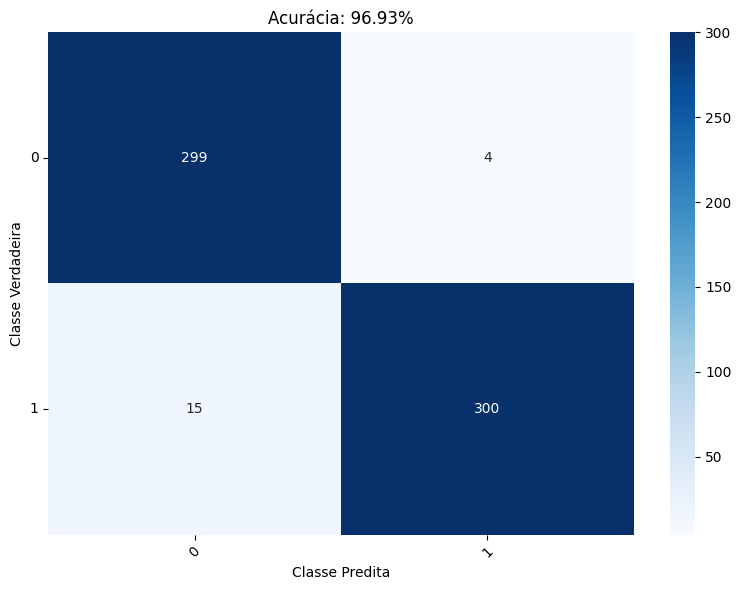

In [97]:
from sklearn.metrics import confusion_matrix, classification_report

y_predict_test = nb_class.predict(X_test)
accuracy = sum(y_true == y_pred for y_true, y_pred in zip(y_test, y_predict_test)) / len(y_test)
print("Acurácia: {:.2f}%".format(accuracy * 100))

cm = confusion_matrix(y_test, y_predict_test)
labels = sorted(set(y_test))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusão')
plt.title("Acurácia: {:.2f}%".format(accuracy * 100))
plt.xlabel('Classe Predita')
plt.ylabel('Classe Verdadeira')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [98]:
results = pd.DataFrame({
    'Texto_Original': list(df.loc[idx_tes, 'X_str']),  # Texto original
    'Real': y_test,
    'Predito': y_predict_test,
    'Acertou': y_test == y_predict_test
})

# Filtrando apenas os erros
erros = results[~results['Acertou']]
print("Frases classificadas incorretamente:")
print(erros[['Texto_Original', 'Real', 'Predito']])

Frases classificadas incorretamente:
                                         Texto_Original  Real  Predito
1436  aba b ab bSyllab b b aba b ab abb abCompa abab...     0        1
2812  distract attention class talkingabout business...     1        0
762   mere look teapot whether hotor cold fact promi...     1        0
732   angel tells many petalsthere buttercup want kn...     1        0
2783  coefficient f gives expansionf f f −y whencef′...     0        1
1364  times hand areless conscious usual ordinary ph...     1        0
1304  supposed due direct action ofthe gods led pros...     1        0
3005  Misuse one tends less producedistorted action ...     1        0
2384  obtaining thingsought assuming reasoning admit...     1        0
449   relations impossibility andcertainty lie every...     0        1
506   harshly mostdishonest selﬁsh people world prai...     1        0
2264  asserted origin geometry sought inEgypt indige...     1        0
749   begin thenotation numbers vertical

In [99]:
for idx, row in erros.iterrows():
    print(f"\nTexto: {row['Texto_Original']}")
    print(f"Classe Real: {row['Real']} | Predita: {row['Predito']}")
    print("="*50)


Texto: aba b ab bSyllab b b aba b ab abb abCompa abab ab bb abab b b ab b aHenceab b bb bSee Huntington op cit This demonstrated follows
Classe Real: 0 | Predita: 1

Texto: distract attention class talkingabout business hand present”If girl forgot teacher might say “I much like tryyour suggestion private please talk class till giveyou leave”If forgot teacher might say—I think inclined tosay—“If cannot remember distract class talking whatis irrelevant business hand
Classe Real: 1 | Predita: 0

Texto: mere look teapot whether hotor cold fact prominent mind sees teapot isthe fact know whether hot cold puts fact alongwith fact—that would much like play picture inthe teapot supposing would burn ﬁngers deals logically withboth facts comes wise conclusion would
Classe Real: 1 | Predita: 0

Texto: angel tells many petalsthere buttercup want know supposed ask thebuttercup angel tells price sugar ought ask yourgrocer angel tells invest money ought ask yourbanker lawyer people foolish enough as